## Pairs Trading Strategies Using Python

When it comes to making money in the stock market, there are a myriad of different ways to make money. And it seems that in the finance community, everywhere you go, people are telling you that you should learn Python. After all, Python is a popular programming language which can be used in all types of fields, including data science. There are a large number of packages that can help you meet your goals, and many companies use Python for development of data-centric applications and scientific computation, which is associated with the financial world.

Most of all Python can help us utilize many different trading strategies that (without it) would by very difficult to analyze by hand or with spreadsheets. One of the trading strategies we will talk about is referred to as **Pairs Trading.**

## Pairs Trading

Pairs trading is a form of *mean-reversion* that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The stratey is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In order to understand pairs trading, we need to understand three mathematical concepts: **Stationarity, Integration, and Cointegration**.

**Note:** This will assume everyone knows the basics of hypothesis testing.

In [64]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

### Stationarity/Non-Stationarity

Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

We will create a function that creates a z-score for probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$


$\mu$ is the mean and $\sigma$ is the standard deviation. The square of the standard deviation, $\sigma^{2}$, is the variance. The empircal rule dictates that 66% of the data should be somewhere between $x+\sigma$ and $x-\sigma$,which implies that the function `numpy.random.normal` is more likely to return samples lying close to the mean, rather than those far away.

In [65]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

From there, we can create two plots that exhibit a stationary and non-stationary time series.

Text(0.5, 1.0, 'Non-Stationary')

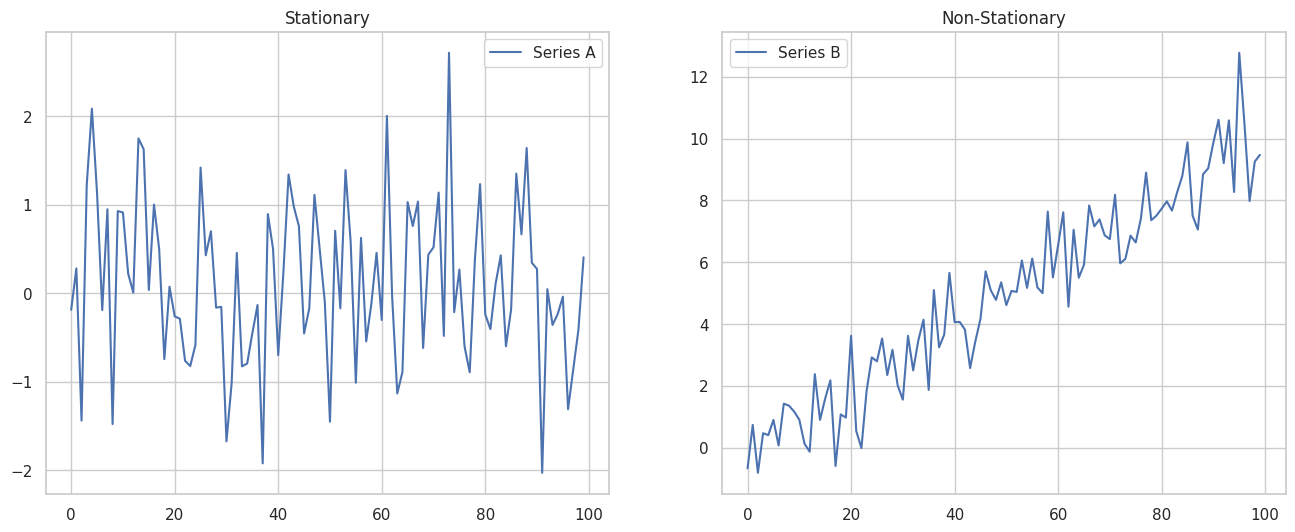

In [66]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)

fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

### Why Stationarity is Important

Many statistical test require that the data being tested are stationary. Using certain statistics on a non-stationary data set may lead to garbage results. As an example, let's take an average through our non-stationary $B$.

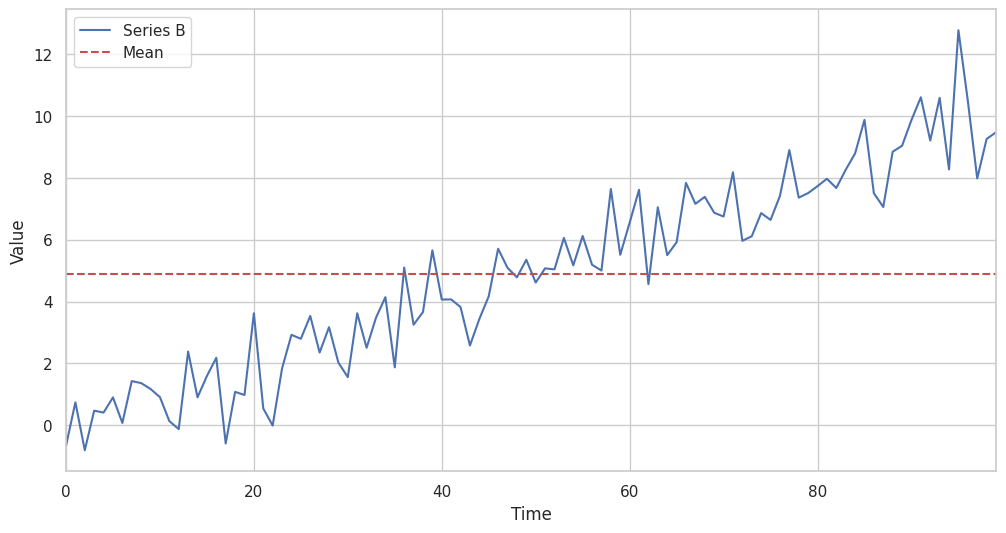

In [67]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The computed mean will show that the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specific time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can distort the analysis, much more subtle problems can arise in practice.

#### Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal of $\mathcal{z}_{t}, \phi (\mathcal{z})=  (1-\phi \mathcal{z})  = 0$, has a root equal to unity.

$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

$$
\begin{aligned}
\Delta y_{t} & = \delta\ + \Delta \mathcal{z}_{t} \\
\Delta\mathcal{z} & = \phi\Delta \mathcal{z}_{t-1}\ +\ \varepsilon_{t}\ -\ \varepsilon_{t-1} \\
\end{aligned}
.$$

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$



$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [68]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [69]:
stationarity_test(A)
stationarity_test(B)

p-value = 3.1947975191728693e-15 The series A is likely stationary.
p-value = 0.9877797335465618 The series B is likely non-stationary.


As we can see, based on the test statistic (which correspnds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be  stationary. On the other hand, Series B is rejected by the hypothesis test, so this time series is likely to be non-stationary.

### Cointegration

The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derviaties theory based on this concept.

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive negaative or varying. If we are delta hedging, then maybe the short timescale orrelation matters, but not if we are holding stocks for a long time in an unhedged portfolio.

We've constructed an example of two cointegrated series. We'll plot the difference between the two now so we can see how this looks.

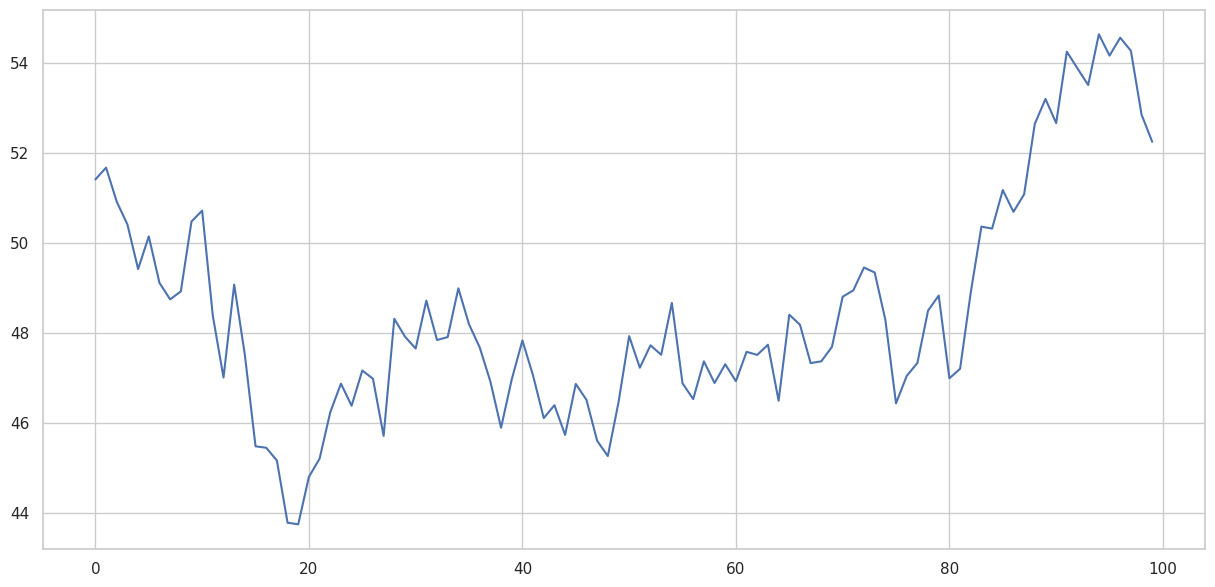

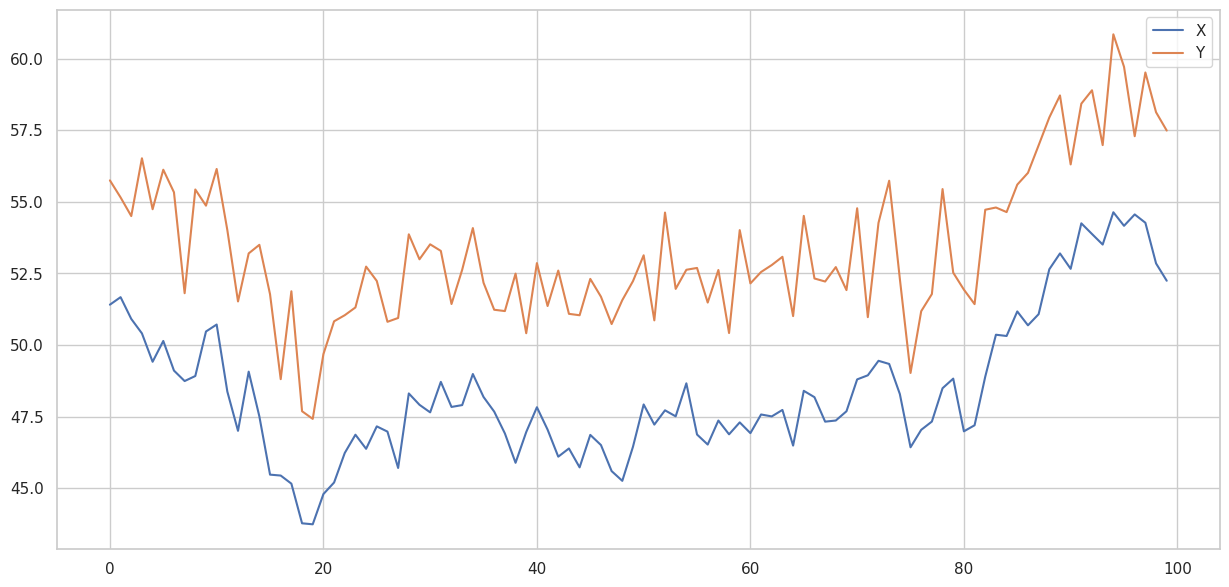

In [70]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

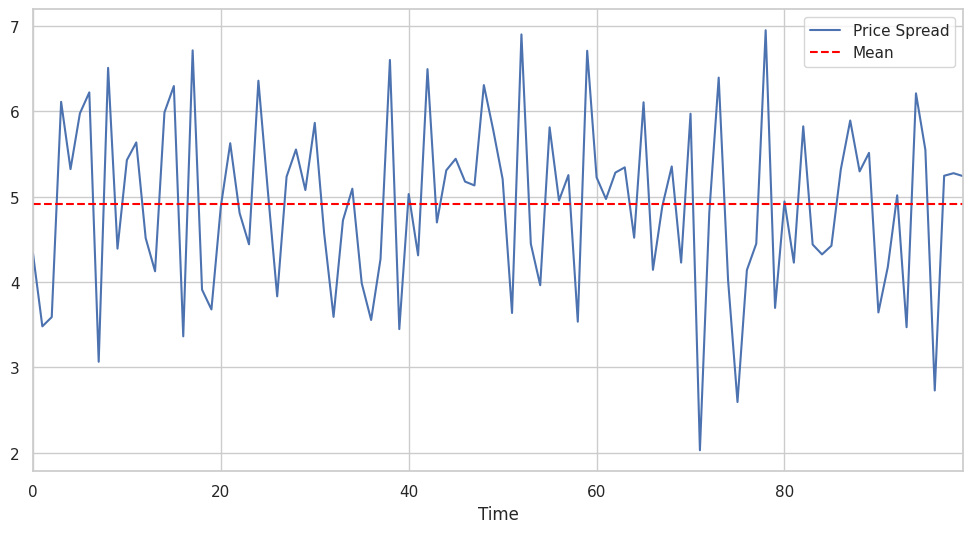

In [71]:

plt.figure(figsize=(12,6))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [72]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

0.23624500341822502


#### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similiar, are anything but similiar. To demonstrate this, we can look at examples of two time series that are correlated, but not cointegrated.

A simple example is two series that just diverge.

(0.0, 99.0)

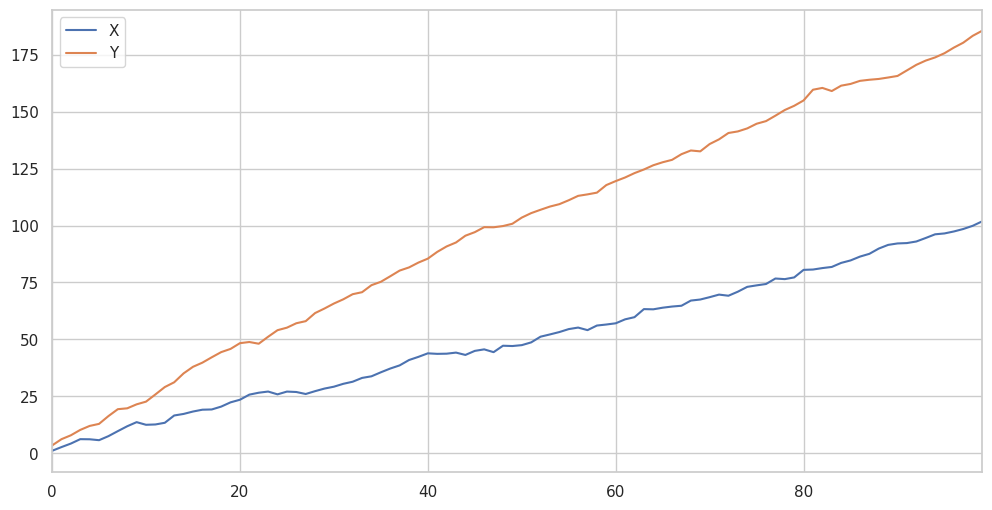

In [73]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)


Next, we can print the correlation coefficient, $r$, and the cointegration test

In [74]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.994312741132802
Cointegration test p-value: 0.7139511293549365


As we can see, there is a very strong (nearly perfect) correlation between series X and Y. However, our p-value for the cointegration test yields a result of 0.7092, which means there is no cointegration between time series X and Y.

Another example of this case is a normally distributed series and a sqaure wave.

Correlation: -0.02919031735525545
Cointegration test p-value: 0.0


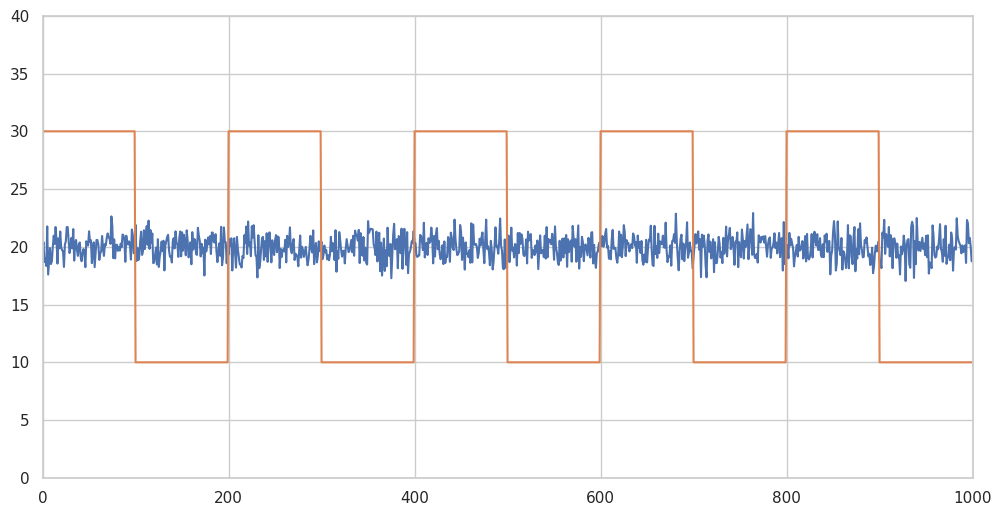

In [75]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

Although the correlation is incredibly low, the p-value shows that these time series are cointegrated.

In [76]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like  # keep if other code expects this

import datetime
import yfinance as yf

def get_data_yahoo(tickers, start=None, end=None, interval="1d", auto_adjust=False):
    """
    Replacement for pandas_datareader.data.get_data_yahoo using yfinance.download.
    - tickers: str or list of str
    - start, end: str or datetime.datetime
    - interval: '1d', '1wk', '1mo', etc.
    - auto_adjust: if True, return adjusted prices as Close and drop 'Adj Close'
    Returns a pandas DataFrame with the same columns as get_data_yahoo for single ticker,
    and a MultiIndex columns DataFrame for multiple tickers.
    """
    # If user passes datetime.date, convert to datetime
    if isinstance(start, (pd.Timestamp,)) is False and isinstance(start, (str, datetime.date, datetime.datetime)):
        # leave as is; yfinance accepts str and datetime
        pass

    # Use yfinance to download
    df = yf.download(tickers, start=start, end=end, interval=interval, group_by='ticker', progress=False, threads=True)

    # If single ticker, yfinance returns columns: ['Open','High','Low','Close','Adj Close','Volume']
    # If auto_adjust requested, optionally replace Close with adjusted close and drop 'Adj Close'
    if isinstance(tickers, str) and auto_adjust:
        if 'Adj Close' in df.columns:
            df['Close'] = df['Adj Close']
            df = df.drop(columns=['Adj Close'])
    return df

# Examples you can run:

# Single ticker example
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2024, 1, 1)
msft = get_data_yahoo("MSFT", start=start, end=end)
print("Single-ticker DataFrame shape:", msft.shape)
print(msft.head())

# Multiple tickers example (returns MultiIndex columns)
tickers = ["AAPL", "MSFT", "GOOG"]
df_multi = get_data_yahoo(tickers, start="2020-01-01", end="2020-01-10")
print("\nMulti-ticker DataFrame shape:", df_multi.shape)
print(df_multi.head())


Single-ticker DataFrame shape: (3522, 5)
Ticker           MSFT                                           
Price            Open       High        Low      Close    Volume
Date                                                            
2010-01-04  22.926263  23.285656  22.903801  23.173346  38409100
2010-01-05  23.098474  23.285658  22.941239  23.180834  49749600
2010-01-06  23.120930  23.270678  22.851387  23.038570  58182400
2010-01-07  22.933746  22.986159  22.604304  22.798975  50559700
2010-01-08  22.671692  23.120932  22.641742  22.956211  51197400

Multi-ticker DataFrame shape: (6, 15)
Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2020-01-02  151.040826  152.895777  150.612762  152.791138  22622100   
2020-01-03  150.603275  152.153817  150.355939  150.888641  21116200   
2020-01-06  149.423690  151.345236  148.

### Data Science in Trading

Before we begin, I’ll first define a function that makes it easy to find cointegrated security pairs using the concepts we’ve already covered.

In [77]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

We are looking through a set of tech companies to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2013 - 2018..

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

In [78]:
import pandas as pd
import datetime
import yfinance as yf

def get_close_prices(tickers, start, end, interval="1d", threads=True, progress=False):
    """
    Replacement for pdr.get_data_yahoo(tickers, start, end)['Close'] using yfinance.
    Returns a DataFrame of Close prices with Date index and columns matching tickers.
    """
    # Download data
    df = yf.download(tickers,
                     start=start,
                     end=end,
                     interval=interval,
                     group_by='ticker',
                     threads=threads,
                     progress=progress)

    # Case 1: MultiIndex columns where one level is 'Close'
    if isinstance(df.columns, pd.MultiIndex):
        # Try to extract second-level 'Close' (common layout: (TICKER, 'Close'))
        try:
            close = df.xs('Close', axis=1, level=1, drop_level=True)
        except Exception:
            # Fallback: try if first level is 'Close' (('Close', TICKER))
            close = df.xs('Close', axis=1, level=0, drop_level=True)
    else:
        # Case 2: Single ticker yields a DataFrame with columns like ['Open','High','Low','Close','Adj Close','Volume']
        if 'Close' in df.columns:
            # When multiple tickers are passed sometimes yfinance returns columns labelled by metric.
            close = df[['Close']].copy()
            # If there were multiple tickers but not MultiIndex, assume columns are labelled ticker Close already
            # we try to reshape: if each column name is 'Close' only then we convert to single column frame
            if len(tickers) > 1 and close.shape[1] == 1:
                # try using yf.download without group_by in future or pass tickers as list to get MultiIndex
                # here we treat df as already containing close prices per ticker (rare)
                close = df
        else:
            # If df already contains only Close prices (some configurations), take df as-is
            close = df.copy()

    # Ensure columns are ordered and named exactly like tickers list
    # If single-ticker provided, ensure result is DataFrame with single column named ticker
    if isinstance(tickers, str):
        ticker_list = [tickers]
    else:
        ticker_list = list(tickers)

    # If close has ticker symbols as columns, align them
    # If close currently has metric names or other labels, attempt to map using intersection
    # Final safe attempt: reindex columns to requested tickers, missing columns become NaN
    cols_intersection = [c for c in ticker_list if c in close.columns]
    if set(cols_intersection) != set(ticker_list):
        # If close columns are tickers, this will reorder, otherwise try to pivot if needed
        try:
            close = close.reindex(columns=ticker_list)
        except Exception:
            # As a last resort, rename the only column to the single ticker if single ticker requested
            if close.shape[1] == 1 and len(ticker_list) == 1:
                close.columns = ticker_list

    # Ensure datetime index and sorted
    close.index = pd.to_datetime(close.index)
    close = close.sort_index()
    return close

# Usage: same as your original
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df_close = get_close_prices(tickers, start, end)
print(df_close.tail())


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFTzMissingError('possibly delisted; no timezone found')


Ticker           EBAY        ADBE       QCOM         SPY       MSFT  JNPR  \
Date                                                                        
2018-12-24  23.345699  205.160004  45.526913  211.372604  88.237259   NaN   
2018-12-26  24.872913  222.949997  47.487160  222.052185  94.264732   NaN   
2018-12-27  25.033667  225.139999  47.597492  223.756973  94.845940   NaN   
2018-12-28  25.221220  223.130005  48.208477  223.468323  94.105385   NaN   
2018-12-31  25.069395  226.240005  48.293335  225.425598  95.211502   NaN   

Ticker           AAPL       ORCL        AMD        IBM        HPQ  
Date                                                               
2018-12-24  34.902637  38.474358  16.650000  75.809250  15.425387  
2018-12-26  37.360527  40.186733  17.900000  78.501358  16.181541  
2018-12-27  37.118073  40.529209  17.490000  80.185715  16.221333  
2018-12-28  37.137093  40.394016  17.820000  79.657135  16.189497  
2018-12-31  37.496040  40.691433  18.459999  80.1082

[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ORCL', 'HPQ'), ('ORCL', 'SPY')]


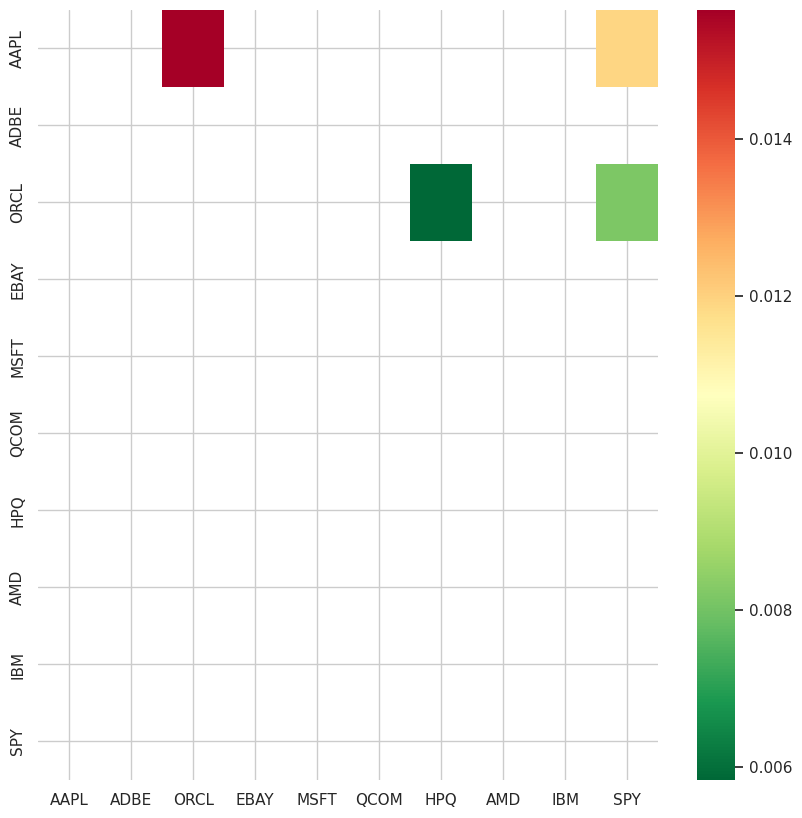

In [79]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded Close prices shape: (1510, 11)
Columns (tickers): ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

Sample tail of Close prices (last 5 rows):
                 AAPL        ADBE       ORCL       EBAY       MSFT       QCOM  \
Date                                                                            
2018-12-24  34.902637  205.160004  38.474358  23.345699  88.237259  45.526913   
2018-12-26  37.360527  222.949997  40.186733  24.872913  94.264732  47.487160   
2018-12-27  37.118073  225.139999  40.529209  25.033667  94.845940  47.597492   
2018-12-28  37.137093  223.130005  40.394016  25.221220  94.105385  48.208477   
2018-12-31  37.496040  226.240005  40.691433  25.069395  95.211502  48.293335   

                  HPQ  JNPR        AMD        IBM         SPY  
Date                                                           
2018-12-24  15.425387   NaN  16.650000  75.809250  211.372604  
2018-12-26  16.181541   NaN  17.900000  78.501358 

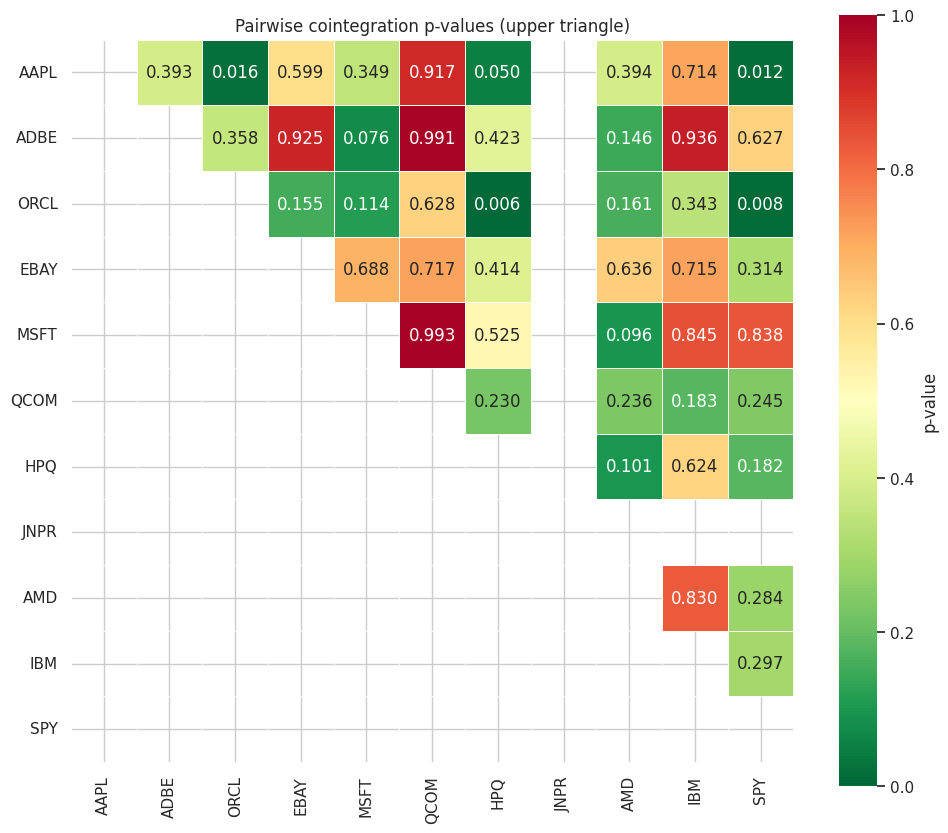

In [80]:
# Complete drop-in replacement: download closes, compute cointegration, print and plot
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import coint

# --- User parameters: adjust dates and tickers here if needed ---
start = datetime.datetime(2013, 1, 1)
end   = datetime.datetime(2019, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

# --- Step 1: Download Close prices reliably using yfinance ---
# yfinance returns nicely structured data for multiple tickers.
raw = yf.download(tickers, start=start, end=end, group_by='ticker', threads=True, progress=False)

def extract_close_from_yf(raw_df, tickers):
    """
    Given raw yfinance output (group_by='ticker'), produce DataFrame of Close prices
    with columns exactly matching tickers list (missing tickers become columns of NaN).
    """
    # If raw has MultiIndex with top level tickers, extract for each ticker
    # Some yfinance versions return: DataFrame where top level is ticker and sublevel is OHLCV
    if isinstance(raw_df.columns, pd.MultiIndex):
        # Attempt to extract for each ticker the 'Close' column
        close_frames = []
        found = []
        for t in tickers:
            try:
                # raw[t]['Close'] works when group_by='ticker'
                s = raw_df[t]['Close'].rename(t)
                found.append(t)
            except Exception:
                # try alternative ordering: level0 = metric, level1 = ticker
                try:
                    s = raw_df.xs(t, axis=1, level=1)['Close'].rename(t)
                    found.append(t)
                except Exception:
                    # missing ticker
                    s = pd.Series(name=t, dtype=float)
            close_frames.append(s)
        # concat along columns, index automatically aligned, resulting df_close will have all tickers
        df_close = pd.concat(close_frames, axis=1)
        return df_close
    else:
        # Single-level columns case: possibly already closelike columns
        # Try common patterns: raw['Close'] or raw.loc[:, tickers]
        if 'Close' in raw_df.columns:
            # if Close is a DataFrame (rare), use it
            close = raw_df['Close']
            # if a Series, ensure DataFrame
            if isinstance(close, pd.Series):
                close = close.to_frame()
            # If columns of close are tickers or single column, try to reindex
            df_close = close.reindex(columns=tickers, fill_value=np.nan)
            return df_close
        # fallback: assume raw_df has columns that are tickers already
        cols = [c for c in raw_df.columns if str(c) in tickers]
        if cols:
            df_close = raw_df[cols].copy()
            df_close.columns = [str(c) for c in df_close.columns]
            # ensure order matches tickers list
            df_close = df_close.reindex(columns=tickers)
            return df_close
        # if nothing matched, raise to inform user
        raise ValueError("Unrecognized yfinance output format. raw_df.columns sample: {}".format(list(raw_df.columns[:20])))

# Build df_close and show diagnostics
try:
    df_close = extract_close_from_yf(raw, tickers)
except Exception as e:
    # Show what we downloaded to help debug
    print("Failed to extract Close prices from yfinance output. raw.columns sample:")
    print(list(raw.columns[:40]))
    raise

# Convert index to datetime and sort
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.sort_index()

print("Downloaded Close prices shape:", df_close.shape)
print("Columns (tickers):", list(df_close.columns))

# Show tail so you can visually confirm
print("\nSample tail of Close prices (last 5 rows):")
print(df_close.tail())

# --- Step 2: Cointegration testing functions ---
def find_cointegrated_pairs_from_close(df_close, significance=0.05, min_obs=60):
    tickers = list(df_close.columns)
    n = len(tickers)
    scores = np.full((n, n), np.nan)
    pvalues = np.full((n, n), np.nan)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            s1 = df_close.iloc[:, i]
            s2 = df_close.iloc[:, j]
            # align indices
            common = s1.index.intersection(s2.index)
            s1c = s1.loc[common].dropna()
            s2c = s2.loc[common].dropna()
            if len(s1c) < min_obs or len(s2c) < min_obs:
                # Not enough overlapping data, skip
                continue
            try:
                tstat, pval, _ = coint(s1c, s2c)
                scores[i, j] = tstat
                pvalues[i, j] = pval
                scores[j, i] = tstat
                pvalues[j, i] = pval
                if (pval is not None) and (pval < significance):
                    pairs.append((tickers[i], tickers[j], float(pval)))
            except Exception:
                # skip problematic pairs silently
                continue
    scores_df = pd.DataFrame(scores, index=tickers, columns=tickers)
    pvalues_df = pd.DataFrame(pvalues, index=tickers, columns=tickers)
    pairs_sorted = sorted(pairs, key=lambda x: x[2])
    return scores_df, pvalues_df, pairs_sorted

# --- Step 3: Run tests and report ---
scores, pvalues, pairs = find_cointegrated_pairs_from_close(df_close, significance=0.05, min_obs=60)

if not pairs:
    print("\nNo significant cointegrated pairs found at p < 0.05 with min_obs=60.")
else:
    print("\nSignificant cointegrated pairs (p < 0.05), sorted by p-value:")
    for a, b, p in pairs:
        print(f"{a} - {b} : p = {p:.6f}")

# Show top-left corner of pvalue matrix for inspection
print("\nP-values matrix sample (top-left 10x10):")
print(pvalues.iloc[:10, :10])

# --- Step 4: Plot upper-triangle heatmap ---
def plot_upper_triangle_pvalues(pvalues_df, figsize=(10,10)):
    pv = pvalues_df.copy()
    tickers = list(pv.columns)
    n = pv.shape[0]
    if n == 0:
        print("No columns to plot.")
        return
    mask_lower = np.tril(np.ones((n, n), dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(pv, mask=mask_lower, annot=True, fmt=".3f", cmap='RdYlGn_r', vmin=0, vmax=1,
                linewidths=0.5, square=True, cbar_kws={"shrink":0.8, "label":"p-value"})
    plt.title("Pairwise cointegration p-values (upper triangle)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_upper_triangle_pvalues(pvalues)

# df_close is now the Close-only DataFrame you can use in downstream code
df = df_close.copy()


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded Close prices shape: (1510, 11)
Columns: ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

NaN count per ticker (total rows = 1510):
              AAPL  ADBE  ORCL  EBAY  MSFT  QCOM  HPQ    JNPR  AMD  IBM  SPY
nan_count      0.0   0.0   0.0   0.0   0.0   0.0  0.0  1510.0  0.0  0.0  0.0
nan_fraction   0.0   0.0   0.0   0.0   0.0   0.0  0.0     1.0  0.0  0.0  0.0

Dropping tickers with >50% NaN or all NaN: ['JNPR']

Final df_close shape after cleaning: (1510, 10)
Columns used: ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'AMD', 'IBM', 'SPY']

Significant cointegrated pairs (p < 0.050), sorted by p-value:
ORCL - HPQ : p = 0.005834
ORCL - SPY : p = 0.008143
AAPL - SPY : p = 0.011911
AAPL - ORCL : p = 0.015644

P-values matrix sample (top-left 10x10):
          AAPL      ADBE      ORCL      EBAY      MSFT      QCOM       HPQ  \
AAPL       NaN  0.392683  0.015644  0.599169  0.349038  0.917095  0.050117   
ADBE  0.392683       NaN  0.35

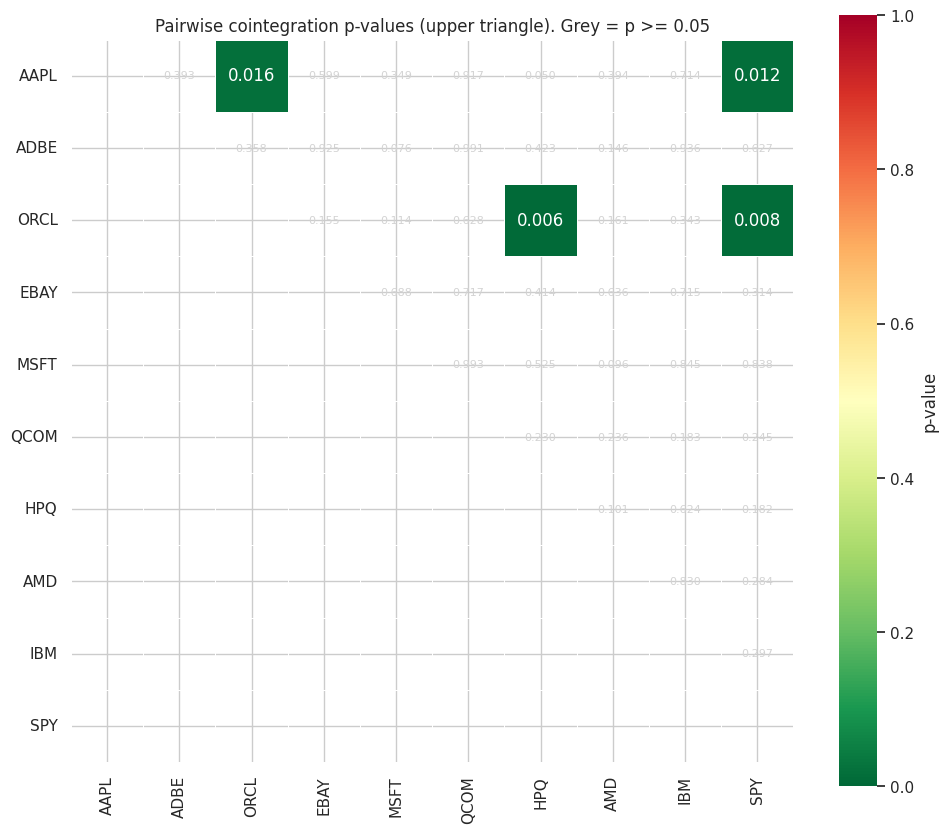


Saved cointegration_pvalues.csv and significant_pairs.csv and cointegration_pvalues_heatmap.png


<Figure size 640x480 with 0 Axes>

In [81]:
# Robust cointegration p-value matrix, diagnostics, and clean upper-triangle heatmap
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import coint

# Parameters
start = datetime.datetime(2013, 1, 1)
end   = datetime.datetime(2019, 1, 1)
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']
min_obs = 60       # minimum overlapping observations to run coint
significance = 0.05

# 1) Download closes
raw = yf.download(tickers, start=start, end=end, group_by='ticker', threads=True, progress=False)

def extract_close(raw_df, tickers):
    # Try multiindex top-level ticker -> sublevel OHLC
    if isinstance(raw_df.columns, pd.MultiIndex):
        cols = []
        series_list = []
        for t in tickers:
            try:
                s = raw_df[t]['Close'].rename(t)
            except Exception:
                # fallback: attempt alternative ordering
                try:
                    s = raw_df.xs(t, axis=1, level=1)['Close'].rename(t)
                except Exception:
                    s = pd.Series(dtype=float, name=t)  # empty series for missing ticker
            series_list.append(s)
        df_close = pd.concat(series_list, axis=1)
        return df_close
    # single-level case
    if 'Close' in raw_df.columns:
        close = raw_df['Close']
        if isinstance(close, pd.Series):
            close = close.to_frame()
        return close.reindex(columns=tickers)
    # else assume raw_df columns are tickers already
    cols = [c for c in raw_df.columns if str(c) in tickers]
    df_close = raw_df[cols].copy()
    df_close.columns = [str(c) for c in df_close.columns]
    return df_close

df_close = extract_close(raw, tickers)
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.sort_index()

# Diagnostics about missing or sparse tickers
nan_counts = df_close.isna().sum()
total_rows = df_close.shape[0]
sparsity = (nan_counts / total_rows).round(3)
print("Downloaded Close prices shape:", df_close.shape)
print("Columns:", list(df_close.columns))
print("\nNaN count per ticker (total rows = {}):".format(total_rows))
print(pd.DataFrame({'nan_count': nan_counts, 'nan_fraction': sparsity}).transpose())

# Drop columns that are completely NaN or have very high missing fraction (> 50%)
threshold = 0.5
bad = [c for c in df_close.columns if df_close[c].isna().mean() > threshold or df_close[c].isna().all()]
if bad:
    print("\nDropping tickers with >50% NaN or all NaN:", bad)
    df_close = df_close.drop(columns=bad)

# Option: forward/backward fill small gaps to increase overlapping observations
# Use with caution. Here we fill up to 2 consecutive NaNs. Comment/uncomment as needed.
df_close = df_close.fillna(method='ffill', limit=2).fillna(method='bfill', limit=2)

# Final shape after cleaning
print("\nFinal df_close shape after cleaning:", df_close.shape)
print("Columns used:", list(df_close.columns))

# 2) Pairwise cointegration tests on cleaned close DataFrame
def find_cointegrated_pairs(df_close, significance=0.05, min_obs=60):
    tickers = list(df_close.columns)
    n = len(tickers)
    scores = np.full((n,n), np.nan)
    pvalues = np.full((n,n), np.nan)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            s1 = df_close.iloc[:, i]
            s2 = df_close.iloc[:, j]
            common = s1.index.intersection(s2.index)
            s1c = s1.loc[common].dropna()
            s2c = s2.loc[common].dropna()
            if len(s1c) < min_obs or len(s2c) < min_obs:
                continue
            try:
                tstat, pval, _ = coint(s1c, s2c)
                scores[i, j] = tstat
                pvalues[i, j] = pval
                scores[j, i] = tstat
                pvalues[j, i] = pval
                if (pval is not None) and (pval < significance):
                    pairs.append((tickers[i], tickers[j], float(pval)))
            except Exception:
                continue
    scores_df = pd.DataFrame(scores, index=tickers, columns=tickers)
    pvalues_df = pd.DataFrame(pvalues, index=tickers, columns=tickers)
    pairs_sorted = sorted(pairs, key=lambda x: x[2])
    return scores_df, pvalues_df, pairs_sorted

scores, pvalues, pairs = find_cointegrated_pairs(df_close, significance=significance, min_obs=min_obs)

# 3) Report pairs and pvalue matrix sample
if pairs:
    print("\nSignificant cointegrated pairs (p < {:.3f}), sorted by p-value:".format(significance))
    for a, b, p in pairs:
        print(f"{a} - {b} : p = {p:.6f}")
else:
    print("\nNo significant cointegrated pairs found at p < {:.3f} with min_obs={}.".format(significance, min_obs))

print("\nP-values matrix sample (top-left 10x10):")
print(pvalues.iloc[:10, :10])

# 4) Clean upper-triangle heatmap
def plot_upper_triangle_pvalues(pvalues_df, significance=0.05, figsize=(10,10)):
    pv = pvalues_df.copy()
    tickers = list(pv.columns)
    n = pv.shape[0]
    if n == 0:
        print("No tickers to plot.")
        return
    # mask lower triangle and diagonal
    mask_lower = np.tril(np.ones((n,n), dtype=bool))
    # create mask for non-significant upper triangle cells so they appear grey
    non_sig_mask = (pv >= significance)
    # combine masks so we hide lower triangle and we will grey non-significant cells by setting them to NaN in a copy
    pv_plot = pv.copy()
    pv_plot_masked = pv_plot.mask(mask_lower)        # hide lower triangle entirely
    # we want to show the upper triangle but grey out non-significant values: annotate with text but show as light grey
    # To grey non-significant cells visually, set their values to np.nan in displayed heatmap and annotate separately
    pv_display = pv_plot_masked.copy()
    pv_display = pv_display.mask(non_sig_mask)  # non-significant upper-triangle become NaN in color map

    plt.figure(figsize=figsize)
    cmap = 'RdYlGn_r'
    sns.heatmap(pv_display, mask=np.isnan(pv_display), annot=True, fmt=".3f", cmap=cmap, vmin=0, vmax=1,
                linewidths=0.5, square=True, cbar_kws={"shrink":0.8, "label":"p-value"})
    # Now annotate non-significant upper-tri cells in grey text
    for i in range(n):
        for j in range(i+1, n):
            val = pv.iloc[i, j]
            if np.isnan(val):
                continue
            if val >= significance:
                plt.text(j+0.5, i+0.5, f"{val:.3f}", ha='center', va='center', color='lightgrey', fontsize=8)

    plt.title("Pairwise cointegration p-values (upper triangle). Grey = p >= {:.2f}".format(significance))
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_upper_triangle_pvalues(pvalues, significance=significance, figsize=(10,10))

# 5) Save output files for inspection
pvalues.to_csv("cointegration_pvalues.csv")
pd.DataFrame(pairs, columns=['ticker_i','ticker_j','pvalue']).to_csv("significant_pairs.csv", index=False)
plt.savefig("cointegration_pvalues_heatmap.png", bbox_inches='tight')

# Expose df_close, pvalues, pairs for later use
print("\nSaved cointegration_pvalues.csv and significant_pairs.csv and cointegration_pvalues_heatmap.png")
df = df_close.copy()


OLS hedge ratio (y ~ const + beta*x): intercept = 20.469427, beta = 1.310444
                            OLS Regression Results                            
Dep. Variable:                   ORCL   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     8566.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:39:06   Log-Likelihood:                -3248.9
No. Observations:                1510   AIC:                             6502.
Df Residuals:                    1508   BIC:                             6512.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

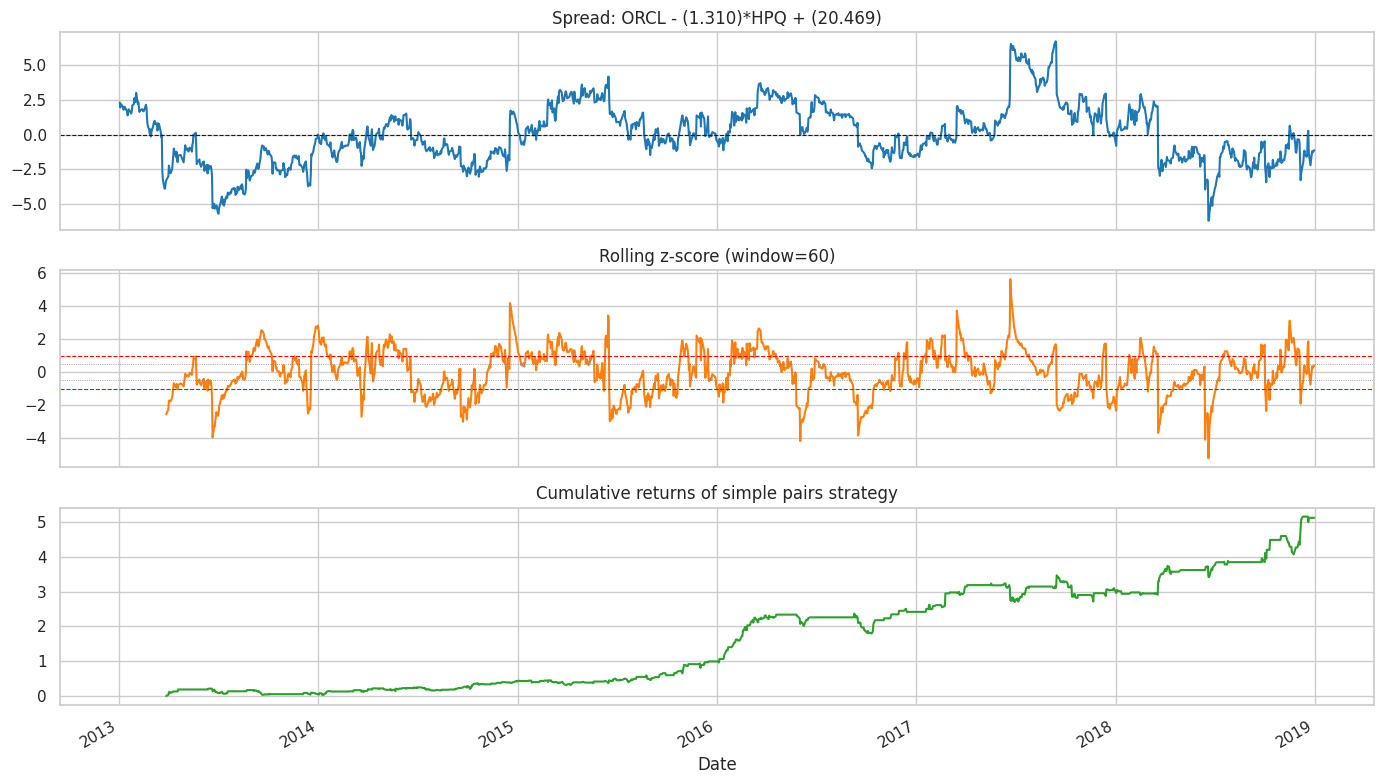

,spread,zscore,ORCL,HPQ,strategy_ret
Date,,,,,
2018-12-19,-0.040842,1.572752,-1.0,1.310444,0.000000
2018-12-20,0.270546,1.858765,-1.0,1.310444,-0.026087
2018-12-21,-1.310172,0.175453,0.0,0.000000,0.021019
2018-12-24,-2.209184,-0.760008,0.0,0.000000,0.000000
2018-12-26,-1.487706,0.024977,0.0,0.000000,0.000000
2018-12-27,-1.197374,0.353803,0.0,0.000000,0.000000
2018-12-28,-1.290848,0.233936,0.0,0.000000,0.000000
2018-12-31,-1.118600,0.398316,0.0,0.000000,0.000000


In [82]:
# Pairs-analysis, spread construction, adf test, zscore, simple backtest and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# PARAMETERS
# choose a pair from the pairs list printed earlier, or set manually
# e.g. top pair from pairs variable if available: pairs[0] == ('ORCL','HPQ', p)
pair = ('ORCL', 'HPQ')   # change as needed, e.g. ('AAPL','SPY')
rolling_window = 60      # window for rolling mean and std for z-score
entry_z = 1.0            # entry threshold in z-score
exit_z = 0.5             # exit threshold in z-score
fee_per_trade = 0.0      # transaction cost per trade as fraction, set if needed

# ensure df_close exists in the notebook and includes the pair columns
if pair[0] not in df_close.columns or pair[1] not in df_close.columns:
    raise ValueError(f"One of the tickers in pair {pair} is not in df_close.columns")

y = df_close[pair[0]].dropna()
x = df_close[pair[1]].dropna()

# align on common dates
common = y.index.intersection(x.index)
y = y.loc[common]
x = x.loc[common]

# 1) Hedge ratio by OLS: regress y on x (no intercept or with intercept)
# Using intercept is often better; final hedge ratio = slope
X = sm.add_constant(x)   # adds intercept
model = sm.OLS(y, X).fit()
intercept, hedge_ratio = model.params[0], model.params[1]
print("OLS hedge ratio (y ~ const + beta*x): intercept = {:.6f}, beta = {:.6f}".format(intercept, hedge_ratio))
print(model.summary())

# 2) Construct spread: spread = y - (intercept + beta * x)
spread = y - (intercept + hedge_ratio * x)

# 3) Stationarity (ADF) test on spread
adf_res = adfuller(spread.dropna(), maxlag=12, autolag='AIC')
adf_stat, adf_pvalue, used_lag, nobs = adf_res[0], adf_res[1], adf_res[2], adf_res[3]
crit_values = adf_res[4]
print("\nADF test on spread:")
print("ADF stat = {:.6f}, p-value = {:.6f}, used_lag = {}, nobs = {}".format(adf_stat, adf_pvalue, used_lag, nobs))
print("Critical values:", crit_values)

# 4) Z-score: use rolling mean/std or full-sample mean/std
zscore_rolling = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()
zscore_full = (spread - spread.mean()) / spread.std()

# choose which zscore to use for signals (rolling is more common)
z = zscore_rolling.dropna()

# 5) Generate signals: long spread when z < -entry_z, short when z > entry_z
positions = pd.DataFrame(index=z.index, columns=[pair[0], pair[1]], dtype=float)
positions[:] = 0.0

# When long spread: long y, short beta * x
positions.loc[z < -entry_z, pair[0]] = 1.0
positions.loc[z < -entry_z, pair[1]] = -hedge_ratio

# When short spread: short y, long beta * x
positions.loc[z > entry_z, pair[0]] = -1.0
positions.loc[z > entry_z, pair[1]] = hedge_ratio

# Exit when |z| < exit_z -> zero positions
positions.loc[abs(z) < exit_z, :] = 0.0

# Forward fill positions so a position stays until an exit signal
positions = positions.ffill().fillna(0.0)

# 6) Compute daily returns of each ticker
rets = df_close[[pair[0], pair[1]]].pct_change().loc[positions.index].fillna(0.0)

# Position scaling: scale so that absolute dollar exposure is 1 for each side or scale to dollar-neutral
# Here we simulate unit notional per long position on y and match dollar exposure on x using beta
# Compute portfolio returns: sum(position_qty * daily_return)
port_rets = (positions.shift(1) * rets).sum(axis=1)  # shift so we use yesterday's position for today's returns
# subtract round-trip simple fee estimate per change in positions (optional)
trades = (positions.shift(1) != positions).any(axis=1)  # True when any position changed
port_rets = port_rets - trades.astype(float) * fee_per_trade

# 7) Performance metrics
cum_ret = (1 + port_rets).cumprod() - 1
total_ret = cum_ret.iloc[-1]
annualized_return = (1 + total_ret) ** (252.0 / len(port_rets.dropna())) - 1 if len(port_rets.dropna()) > 0 else np.nan
annualized_vol = port_rets.std() * np.sqrt(252)
sharpe = (port_rets.mean() * 252) / (port_rets.std() * np.sqrt(252)) if port_rets.std() != 0 else np.nan
win_rate = (port_rets[port_rets != 0] > 0).mean()

print("\nStrategy performance (simple, no leverage):")
print("Total return (fraction): {:.4f}".format(total_ret))
print("Annualized return (approx): {:.4f}".format(annualized_return))
print("Annualized vol: {:.4f}".format(annualized_vol))
print("Sharpe (annualized): {:.4f}".format(sharpe))
print("Win rate (nonzero days): {:.2%}".format(win_rate))

# 8) Plots
plt.figure(figsize=(14,8))
ax = plt.subplot(3,1,1)
spread.plot(ax=ax, color='tab:blue')
ax.set_title(f"Spread: {pair[0]} - ({hedge_ratio:.3f})*{pair[1]} + ({intercept:.3f})")
ax.axhline(spread.mean(), color='k', linestyle='--', linewidth=0.8)
ax.grid(True)

ax2 = plt.subplot(3,1,2, sharex=ax)
z.plot(ax=ax2, color='tab:orange')
ax2.axhline(entry_z, color='red', linestyle='--', linewidth=0.8)
ax2.axhline(-entry_z, color='green', linestyle='--', linewidth=0.8)
ax2.axhline(exit_z, color='grey', linestyle=':', linewidth=0.6)
ax2.axhline(-exit_z, color='grey', linestyle=':', linewidth=0.6)
ax2.set_title(f"Rolling z-score (window={rolling_window})")
ax2.grid(True)

ax3 = plt.subplot(3,1,3, sharex=ax)
cum_ret.plot(ax=ax3, color='tab:green')
ax3.set_title("Cumulative returns of simple pairs strategy")
ax3.grid(True)

plt.tight_layout()
plt.show()

# Optional: show first few rows of positions and port_rets to inspect signals
display(pd.concat([spread.to_frame('spread').tail(8),
                   z.tail(8).to_frame('zscore'),
                   positions.tail(8),
                   port_rets.tail(8).to_frame('strategy_ret')], axis=1))


Our algorithm listed two pairs that are cointegrated: AAPL/EBAY, and ABDE/MSFT. We can analyze their price patterns to make sure there is nothing weird going on.

In [83]:
import pandas as pd
from statsmodels.tsa.stattools import coint

def get_close_series(df, ticker):
    """
    Return a pandas Series of Close prices for `ticker` from df.
    Handles common formats:
      - MultiIndex columns where level contains 'Close' (either level 0 or 1)
      - df['Close'] being a DataFrame of tickers
      - single-level columns where column names are tickers
    Raises KeyError with helpful diagnostic if not found.
    """
    # MultiIndex case
    if isinstance(df.columns, pd.MultiIndex):
        lv0 = df.columns.get_level_values(0)
        lv1 = df.columns.get_level_values(1)
        # common layout: (ticker, OHLC) -> 'Close' in level 1
        if 'Close' in lv1:
            try:
                return df.xs('Close', axis=1, level=1, drop_level=True)[ticker]
            except KeyError:
                # ticker missing in that level
                raise KeyError(f"Ticker {ticker} not found under level 'Close'. Available tickers: {list(df.xs('Close', axis=1, level=1, drop_level=True).columns)}")
        # alternative layout: (OHLC, ticker) -> 'Close' in level 0
        if 'Close' in lv0:
            try:
                return df.xs('Close', axis=1, level=0, drop_level=True)[ticker]
            except KeyError:
                raise KeyError(f"Ticker {ticker} not found under level 'Close' (level 0). Available tickers: {list(df.xs('Close', axis=1, level=0, drop_level=True).columns)}")
        # fallback: flatten names and try to find a close-like column containing ticker
        flat = df.copy()
        flat.columns = ['__'.join(map(str, c)) for c in flat.columns.values]
        for col in flat.columns:
            if ticker in col and col.lower().endswith('close'):
                return flat[col]
        raise KeyError(f"Could not find Close for ticker {ticker} in MultiIndex columns. Column sample: {list(df.columns[:20])}")

    # Single-level columns case
    # If df contains a 'Close' column that is itself a DataFrame of tickers (rare)
    if 'Close' in df.columns:
        close = df['Close']
        if isinstance(close, pd.DataFrame):
            if ticker in close.columns:
                return close[ticker]
        elif isinstance(close, pd.Series):
            # single-ticker DataFrame with Close column
            return close

    # If ticker is directly a column name
    if ticker in df.columns:
        return df[ticker]

    # Try fuzzy matching: columns containing ticker name and 'close'
    for col in df.columns:
        name = str(col)
        if ticker == name or (ticker in name and 'close' in name.lower()):
            return df[col]

    # Nothing found
    raise KeyError(f"Could not locate Close series for ticker '{ticker}'. df.columns sample: {list(df.columns[:20])}")


# --- Usage: compute cointegration p-value between two tickers ---
# Replace `df` with your DataFrame variable name if different
try:
    S1 = get_close_series(df, 'ADBE').dropna()
    S2 = get_close_series(df, 'MSFT').dropna()
except KeyError as e:
    # helpful diagnostic print and re-raise
    print("Error locating series:", e)
    raise

# align on common dates and drop any remaining NaNs
common_idx = S1.index.intersection(S2.index)
S1c = S1.loc[common_idx].dropna()
S2c = S2.loc[common_idx].dropna()

# optional quick check
print("Aligned sample length:", len(S1c))
if len(S1c) < 30:
    print("Warning: small overlap length may make test unreliable")

# run Engle-Granger cointegration test
score, pvalue, _ = coint(S1c, S2c)
print("Cointegration test p-value (ADBE vs MSFT) =", pvalue)


Aligned sample length: 1510
Cointegration test p-value (ADBE vs MSFT) = 0.0764873533780188


The p-value is a probability used in statistical hypothesis testing to help determine the significance of a result. It quantifies the evidence against a null hypothesis: a small p-value (typically less than a predetermined significance level of 0.05) indicates strong evidence against the null hypothesis, leading to its rejection and the conclusion that the result is statistically significant and likely not due to random chance. Conversely, a large p-value (greater than 0.05) suggests the observed data is consistent with the null hypothesis, meaning the result is not statistically significant and there is insufficient evidence to conclude a real effect or relationship exists.

#### Calculating the Spread

Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as mentioned with the Engle-Granger method before.

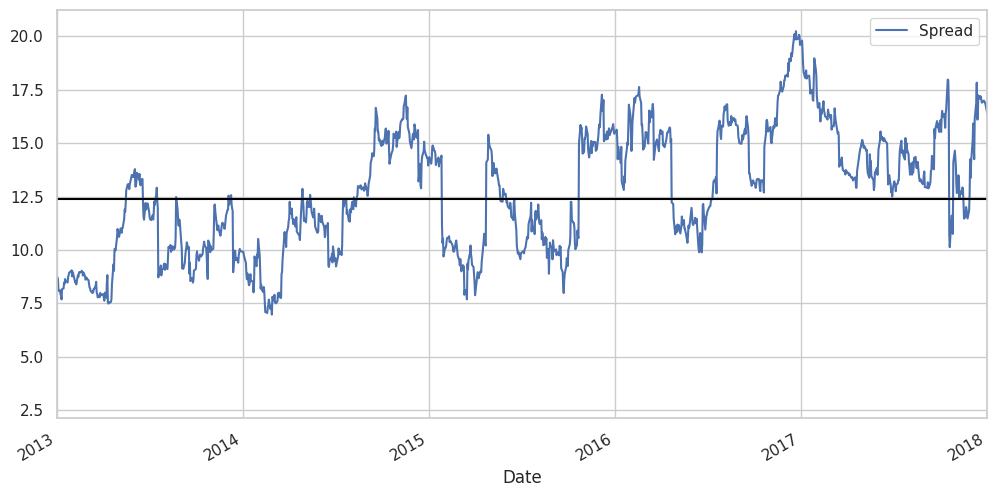

In [84]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

Alternatively, we can examine the ration between the two time series

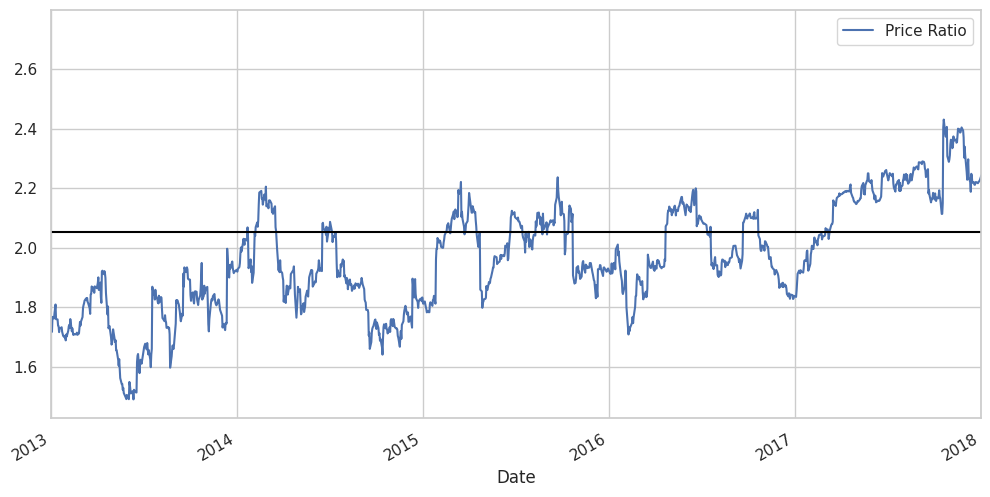

In [85]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/SYMC tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

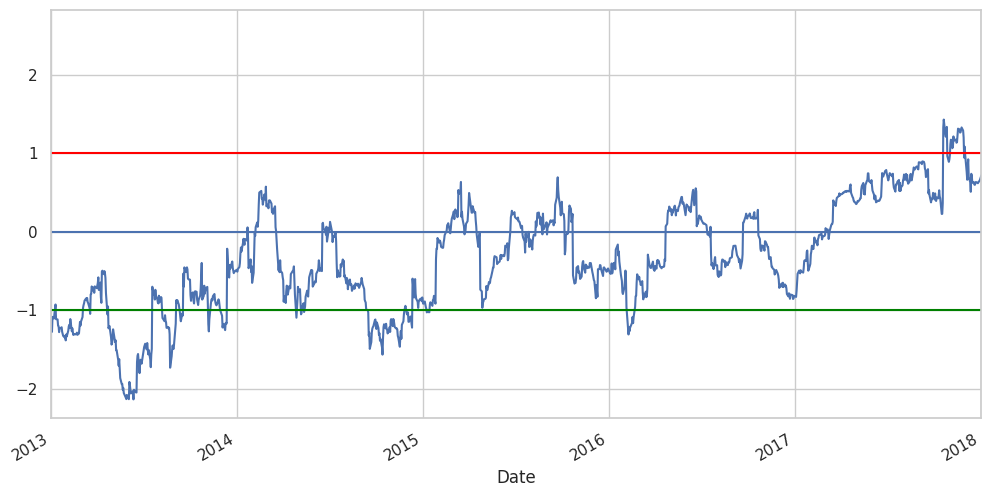

In [86]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock?

#### Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [87]:
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) * .70 )

1057.0


In [88]:
train = ratios[:1057]
test = ratios[1057:]

#### Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

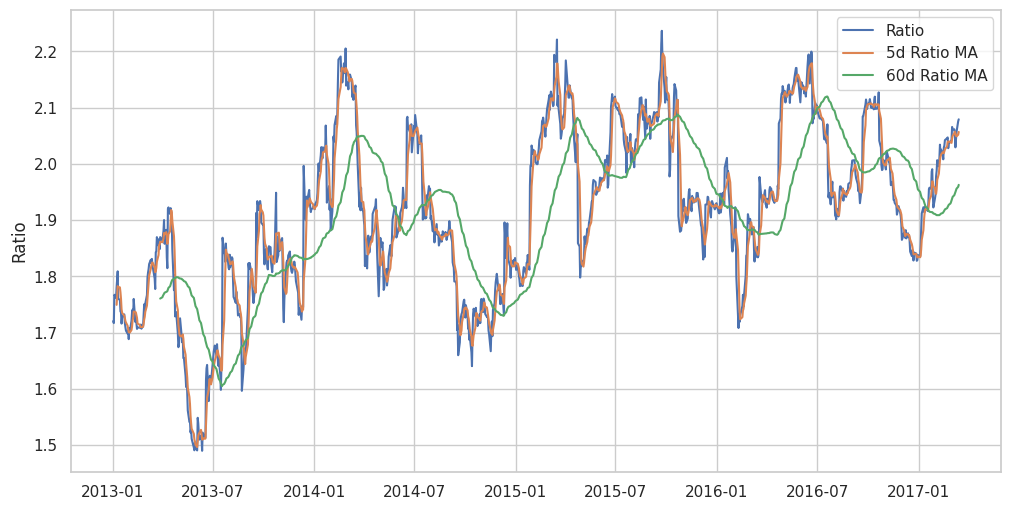

In [89]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

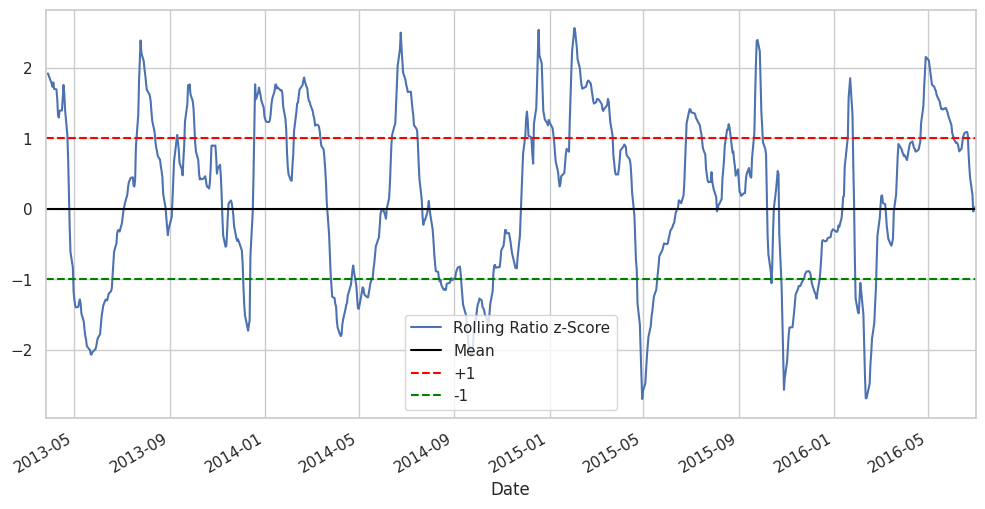

In [90]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

#### Training Optimizing

We can use our model on actual data

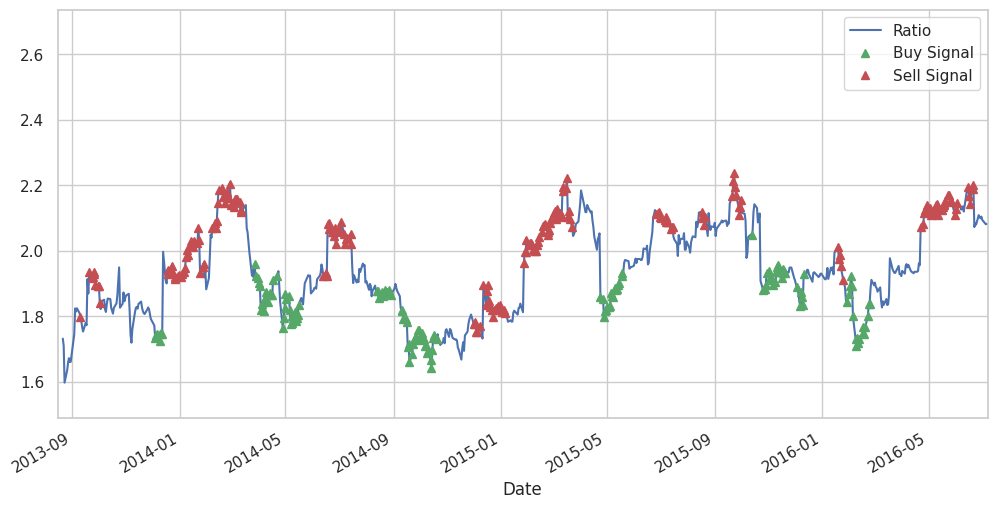

In [91]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

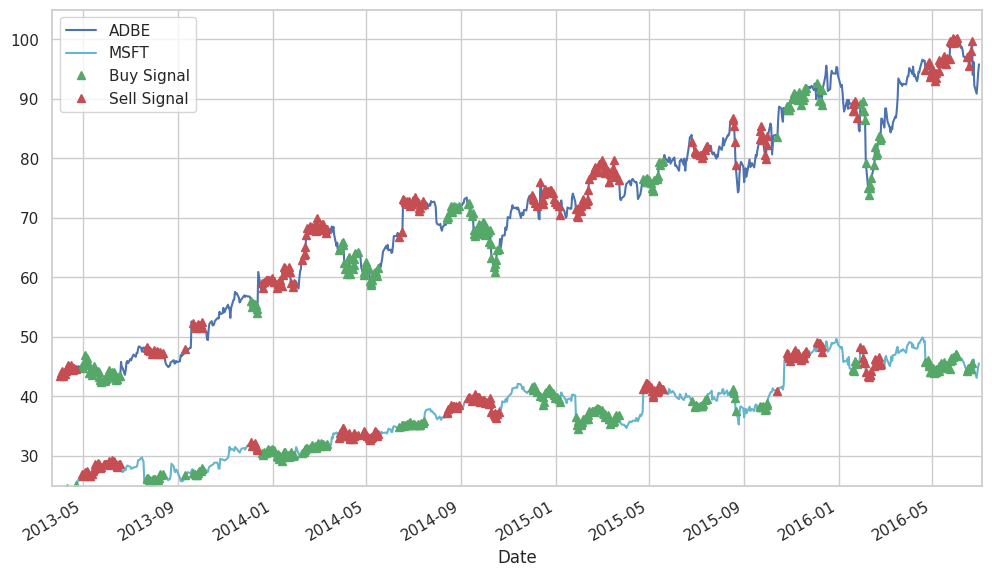

In [92]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

Now, how much can we expect to make of this strategy?

In [93]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [94]:
trade(df['ADBE'].iloc[881:], df['MSFT'].iloc[881:], 60, 5)

np.float64(609.9265942911701)

Not a bad profit for a strategy that is made from stratch.

### Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

#### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

#### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

#### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

#### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.

### Addendum: Finding the Optimal Trading Window

We also need to give a special mention for overfitting. Overfitting is the most dangerous pitfall of a trading strategy. An overfit algorithm may peform great on a backtest but fails miserably on new unnseen data -- this means it has not really uncovered any trend in data and no real predictive power.

In our model, we used rolling parameter estimates and we may want to use an optimal window length. We may decide to simply iterate over all possible, reasonable window length and pick the length based on which our model performs the best.

Below I have written a simple loop to create window lengths based on our PnL of training data to find the best window.

In [95]:
# Find the window length 0-254
# that gives the highest returns using this strategy
length_scores = [trade(df['ADBE'].iloc[:1057],
                df['MSFT'].iloc[:1057], l, 5)
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)


Best window length: 241


As we can see, our optimal window length is from 5 days to 250 days. We can compare this with the testing data and see that this window length is far from optimal. This is because our original choice for the window length probability overfit the sample data.

In [96]:
length_scores2 = [trade(df['ADBE'].iloc[1057:],
                  df['MSFT'].iloc[1057:],l,5)
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset,
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

241 day window: 1873.1183393970555
251 day window: 2478.057763485199


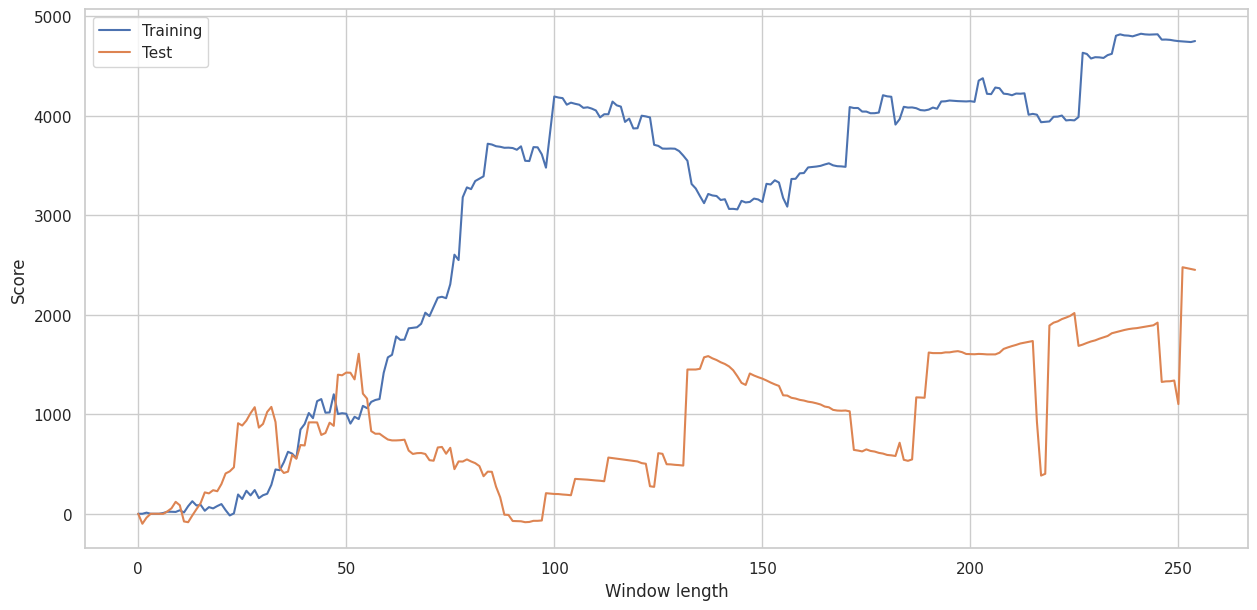

In [97]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

So really using anything above ~50 days would be a good choice for our trading window. To avoid overfitting, we can use economic reasoning to pick our window length. We can also use other techniques such as Kalman filters, which doesn't require us to specify a length. I'll cover this later in another notebook.